In [33]:
%matplotlib inline
import numpy as np
import theano.tensor as tt
import pymc3 as pm

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [155]:
data =  pd.read_csv("data/FruitflyDataReduced.csv")
data["CompanionNumber"] = data["CompanionNumber"].astype("category", inplace=True)

In [147]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()

companion_categories = label_binarizer.fit_transform(data["CompanionNumber"])

['Pregnant8' 'None0' 'Pregnant1' 'Virgin1' 'Virgin8']
0     Pregnant8
1     Pregnant8
2     Pregnant8
3     Pregnant8
4     Pregnant8
5     Pregnant8
6     Pregnant8
7     Pregnant8
8     Pregnant8
9     Pregnant8
10    Pregnant8
11    Pregnant8
12    Pregnant8
13    Pregnant8
14    Pregnant8
15    Pregnant8
16    Pregnant8
17    Pregnant8
18    Pregnant8
19    Pregnant8
20    Pregnant8
21    Pregnant8
22    Pregnant8
23    Pregnant8
24    Pregnant8
25        None0
26        None0
27        None0
28        None0
29        None0
Name: CompanionNumber, dtype: object


array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [162]:
from theano.tensor import _shared

data_stddev = data["Longevity"].std()
data_mean = data["Longevity"].mean()
indexes = data.CompanionNumber.cat.codes.values
#print("data_stddev: {} data_mean: {} data_length {}".format(data_stddev, data_mean, len(data)))

In [175]:
yMean = data_mean
ySD = data_stddev
print(ySD)
def gammaShRaFromModeSD(mode, sd):
    rate = (mode + np.sqrt( mode**2 + 4 * sd**2 ) ) / ( 2 * sd**2 )
    shape = 1 + mode * rate
    return(shape, rate)

17.563892580537072


In [171]:
with pm.Model() as model:
    #calculated alpha and beta so mode = data_stddev / 2 and stddev = 2* data_stddev
    #alpha = 2.92 
    #beta  = 0.335
    shape, rate = gammaShRaFromModeSD(ySD/2, 2*ySD)
    aSigma = pm.Gamma('aSigma', shape, rate)
    ao = pm.Normal('ao', yMean, tau=1/(ySD*5)**2)
    a = pm.Normal("a", 0.0, tau=1 / (aSigma **2), shape=companion_categories.shape[1])
    
    ySigma = pm.Uniform('ySigma', lower=ySD / 100, upper=ySD * 10)
    
    
    pm.Normal("obs", ao + (a[indexes]), ySigma, observed=observations)
    
    m = pm.Deterministic("m", ao + a)
    bo = pm.Deterministic("bo", tt.mean(m))
    b = pm.Deterministic("b", m - bo)
    
    trace = pm.sample(20000)
    burned_trace = trace[1000:]  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ySigma, a, ao, aSigma]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:25<00:00, 478.34draws/s]
The acceptance probability does not match the target. It is 0.8887196681763113, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117b8d4a8>,
      dtype=object)

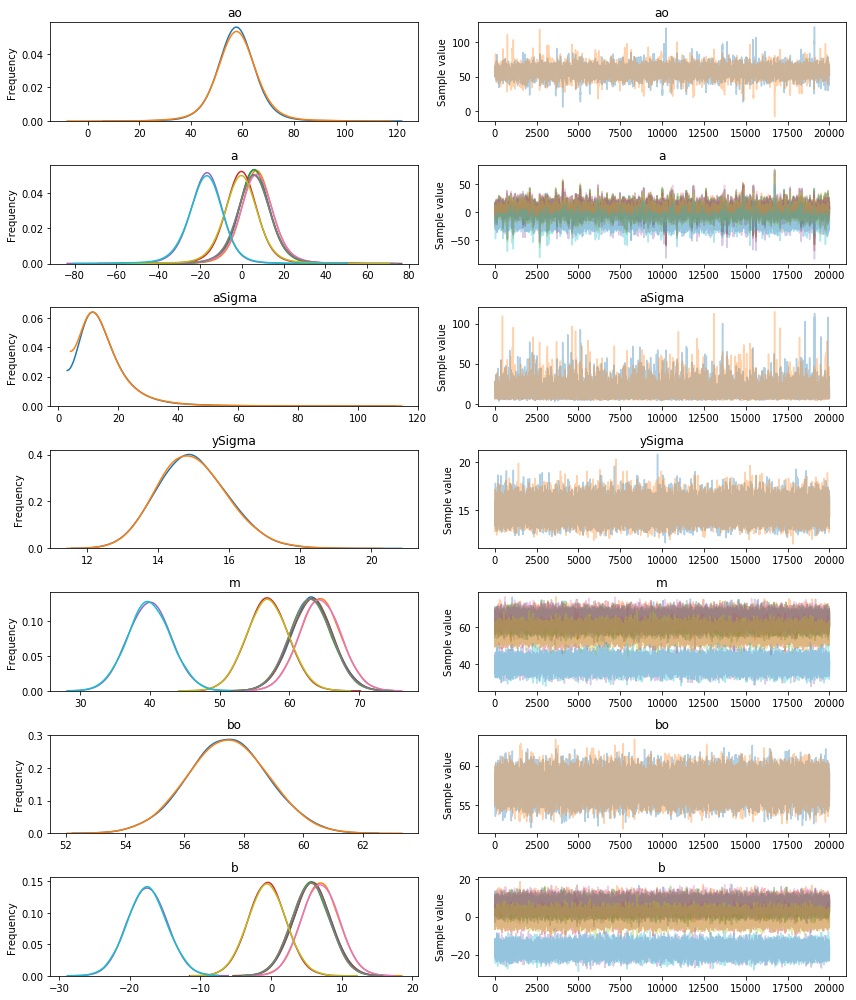

In [172]:
#plt.title(r"Posterior distributions of the variables $\mu$")
#print(burned_trace["b"].mean(axis=0))
#print(burned_trace["bo"].mean())

pm.traceplot(trace)
#plt.hist(burned_tracconstrained_baselinee["mu"], histtype='stepfilled', bins=35, alpha=0.85,label=r"posterior of $\mu$", normed=True)

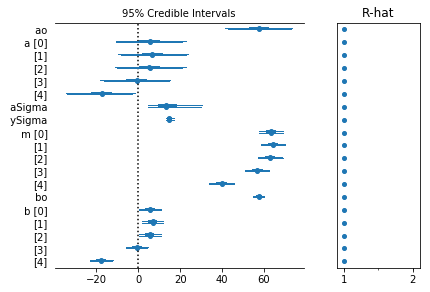

In [176]:
pm.forestplot(trace)

In [179]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
ao,57.489148,7.803481,0.115597,41.686789,72.839738,4809.690581,1.000016
a__0,5.696623,8.120816,0.114865,-9.977135,22.333425,5316.712225,1.000024
a__1,6.865482,8.117301,0.116842,-8.836139,23.456977,5292.319849,0.999999
a__2,5.497138,8.135713,0.118013,-10.687991,21.721062,5267.579494,1.000002
a__3,-0.674517,8.120222,0.115701,-16.643868,15.589151,5380.443744,1.000007
a__4,-17.623086,8.176697,0.116839,-33.990599,-1.959917,5211.946003,1.000054
aSigma,15.153380,8.069521,0.089534,4.608457,30.250887,8667.737155,1.000012
ySigma,14.967983,0.977486,0.006040,13.174199,16.944750,21892.393177,0.999999
m__0,63.185771,2.957385,0.012220,57.363733,69.049286,54342.709708,0.999980
m__1,64.354630,2.945689,0.013077,58.680561,70.205340,53532.478145,0.999987


In [181]:
None0 = burned_trace["m"][:,0]
Pregnant1 = burned_trace["m"][:,1]
Pregnant8 = burned_trace["m"][:,2]
Virgin1 = burned_trace["m"][:,3]
Virgin8 = burned_trace["m"][:,4]
scale = burned_trace["ySigma"]

In [194]:
def plot_mustache(var, sd, j, axis, width=.75):
    for i in np.arange(start=0, stop=len(var), step=int(len(var)*.1)):
        rv = norm(loc=var[i], scale=sd[i])
        yrange = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 100)
        xrange = rv.pdf(yrange)
        xrange_scaled = xrange*(width/xrange.max())
        axis.plot(-xrange_scaled+j, yrange, color=color, alpha=.6)

(38000,)


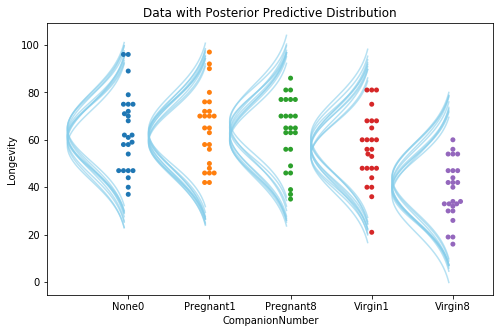

In [192]:
from scipy.stats import norm
color = '#87ceeb'
fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.set_title('Data with Posterior Predictive Distribution')

sns.swarmplot('CompanionNumber', 'Longevity', data=data, ax=ax);
ax.set_xlim(xmin=-1)

for i, grp in enumerate([None0, Pregnant1, Pregnant8, Virgin1, Virgin8]):
    plot_mustache(grp, scale, i, ax)

[<matplotlib.axes._subplots.AxesSubplot object at 0x12b1d1a90>, <matplotlib.axes._subplots.AxesSubplot object at 0x117da0358>, <matplotlib.axes._subplots.AxesSubplot object at 0x115df7630>, <matplotlib.axes._subplots.AxesSubplot object at 0x117e03390>]


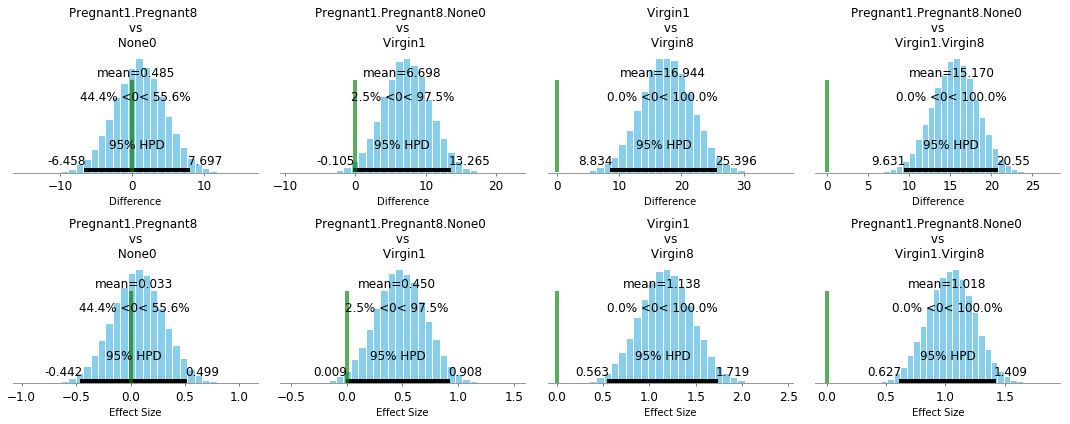

In [197]:
fig, axes = plt.subplots(2,4, figsize=(15,6))
contrasts = [np.mean([Pregnant1, Pregnant8], axis=0)-None0,
             np.mean([Pregnant1, Pregnant8, None0], axis=0)-Virgin1,
             Virgin1-Virgin8,
             np.mean([Pregnant1, Pregnant8, None0], axis=0)-np.mean([Virgin1, Virgin8], axis=0)]

contrast_titles = ['Pregnant1.Pregnant8 \n vs \n None0',
                   'Pregnant1.Pregnant8.None0 \n vs \n Virgin1',
                   'Virgin1 \n vs \n Virgin8',
                   'Pregnant1.Pregnant8.None0 \n vs \n Virgin1.Virgin8']

for contr, ctitle, ax_top, ax_bottom in zip(contrasts, contrast_titles, fig.axes[:4], fig.axes[4:]):
    pm.plot_posterior(contr, ref_val=0, color=color, ax=ax_top)
    pm.plot_posterior(contr/scale, ref_val=0, color=color, ax=ax_bottom)
    ax_top.set_title(ctitle)
    ax_bottom.set_title(ctitle)
    ax_top.set_xlabel('Difference')
    ax_bottom.set_xlabel('Effect Size')
fig.tight_layout()